In [12]:
# Lint as: python3
# Copyright 2019 Deepmind Technologies Limited.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Plotting tools for IODINE."""
# pylint: disable=unused-import, missing-docstring, unused-variable
# pylint: disable=invalid-name, unexpected-keyword-arg
"""Modified by Patrick Emami."""
import functools
from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

In [2]:
def get_random_mask_plot_colors(nr_colors):
    """Get nr_colors uniformly spaced hues to plot mask values."""
    hsv_colors = np.ones((nr_colors, 3), dtype=np.float32)
    hsv_colors[:, 0] = np.linspace(0, 1, nr_colors, endpoint=False)
    color_conv = hsv_to_rgb(hsv_colors)
    np.random.shuffle(color_conv)
    np.random.shuffle(color_conv)
    
    return color_conv    

def get_mask_plot_colors(nr_colors):
    """Get nr_colors uniformly spaced hues to plot mask values."""
    hsv_colors = np.ones((nr_colors, 3), dtype=np.float32)
    hsv_colors[:, 0] = np.linspace(0, 1, nr_colors, endpoint=False)
    color_conv = hsv_to_rgb(hsv_colors)
    return color_conv

def clean_ax(ax, color=None, lw=4.0):
  ax.set_xticks([])
  ax.set_yticks([])
  if color is not None:
    for spine in ax.spines.values():
      spine.set_linewidth(lw)
      spine.set_color(color)


def optional_ax(fn):

  def _wrapped(*args, **kwargs):
    if kwargs.get("ax", None) is None:
      figsize = kwargs.pop("figsize", (4, 4))
      fig, ax = plt.subplots(figsize=figsize)
      kwargs["ax"] = ax
    return fn(*args, **kwargs)

  return _wrapped


def optional_clean_ax(fn):

  def _wrapped(*args, **kwargs):
    if kwargs.get("ax", None) is None:
      figsize = kwargs.pop("figsize", (4, 4))
      fig, ax = plt.subplots(figsize=figsize)
      kwargs["ax"] = ax
    color = kwargs.pop("color", None)
    lw = kwargs.pop("lw", 4.0)
    res = fn(*args, **kwargs)
    clean_ax(kwargs["ax"], color, lw)
    return res

  return _wrapped


@optional_clean_ax
def show_img(img, mask=None, ax=None, norm=False):
  if norm:
    vmin, vmax = np.min(img), np.max(img)
    img = (img - vmin) / (vmax - vmin)
  if mask is not None:
    img = img * mask + np.ones_like(img) * (1.0 - mask)

  return ax.imshow(img.clip(0.0, 1.0), interpolation="nearest")


@optional_clean_ax
def show_mask(m, ax, color_conv=None):
  if color_conv is None:
      color_conv = get_mask_plot_colors(m.shape[0])
  color_mask = np.dot(np.transpose(m, [1, 2, 0]), color_conv)
  return ax.imshow(color_mask.clip(0.0, 1.0), interpolation="nearest")


@optional_clean_ax
def show_mat(m, ax, vmin=None, vmax=None, cmap="viridis"):
  return ax.matshow(
      m[..., 0], cmap=cmap, vmin=vmin, vmax=vmax, interpolation="nearest")


@optional_clean_ax
def show_coords(m, ax):
  vmin, vmax = np.min(m), np.max(m)
  m = (m - vmin) / (vmax - vmin)
  color_conv = get_mask_plot_colors(m.shape[-1])
  color_mask = np.dot(m, color_conv)
  return ax.imshow(color_mask, interpolation="nearest")

def example_plot(rinfo,
                 b=0,
                 t=-1,
                 mask_components=False,
                 size=2,
                 column_titles=True,
                 attention=False):
  image = rinfo["data"]["image"][b]
  recons = rinfo["outputs"]["recons"][b, t]
  pred_mask = rinfo["outputs"]["pred_mask"][b, t]
  components = rinfo["outputs"]["components"][b, t]
  if attention:
    attn = rinfo["outputs"]["attention"][b,t]

  K, H, W, C = components.shape
  colors = get_mask_plot_colors(K)
  
  nprefix_imgs = 3 if not attention else 4
  nrows = 1
  ncols = nprefix_imgs + K
  fig, axes = plt.subplots(ncols=ncols, figsize=(ncols * size, nrows * size))

  show_img(image, ax=axes[0], color="#000000")
  show_img(recons, ax=axes[1], color="#000000")
  show_mask(pred_mask[..., 0], ax=axes[2], color="#000000")
  if attention:
      show_mask(attn[..., 0], ax=axes[3], color="#000000")
      for k in range(K):
        mask = attn[k] if mask_components else None
        show_img(image, ax=axes[k + nprefix_imgs], color=colors[k], mask=mask)
  else:     
      for k in range(K):
        mask = pred_mask[k] if mask_components else None
        show_img(components[k], ax=axes[k + nprefix_imgs], color=colors[k], mask=mask)

  if column_titles:
    labels = ["Image", "Recons", "Mask"
             ]
    if attention:
        labels += [r"Attention $\rightarrow$"]
    for ax, title in zip(axes, labels):
      ax.set_title(title, fontsize=16)
  plt.subplots_adjust(hspace=0.035, wspace=0.035)
  return fig

def get_image_row_from_matrix(img, rows, padding=2, side_length=64):
    """
    img is [3,H,W]. Each row is padded by 2 pixels top and bottom.
    Extract rows accounting for padding
    """
    imgs = []
    for r in rows:
        start = side_length * r + (padding*2*r)
        end = start + padding + side_length + padding
        imgs += [img[:,start:end,:]]
    return imgs

def make_gif(xs, savefile, num_frames=6, side=98):
    """
    Let xs be a List of images of shape [H,W,C]
    """
    if not type(xs) is list:
        H, W, C = xs.shape
        sl = W // num_frames
        xs_ = []
        for i in range(1,num_frames+1):
            xs_ += [xs[:, (i-1)*side:(i*side)]]
        xs = xs_
    xs = [(255. * x).astype('int32') for x in xs]        
    gif = ImageSequenceClip(xs, fps=4)
    gif.write_gif(savefile, fps=4)

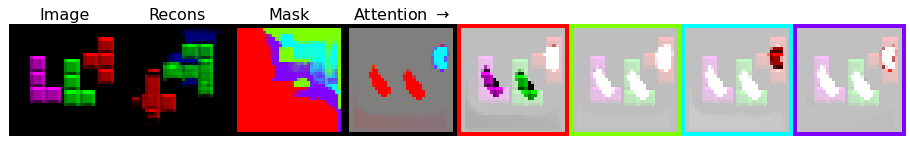

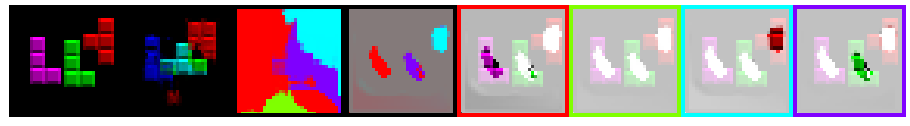

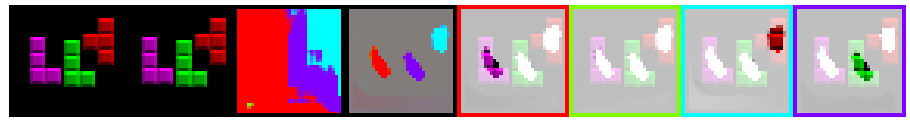

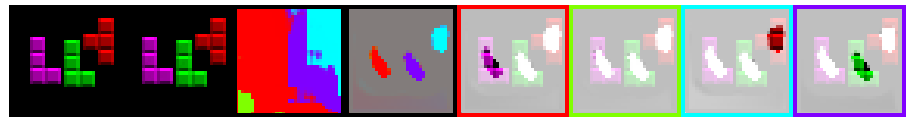

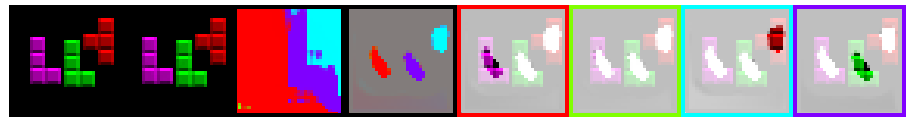

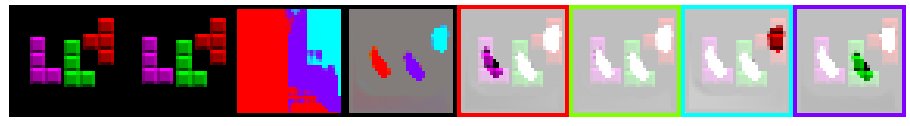

In [12]:
rinfo = pkl.load(open(os.path.join('./visualizations', 'emorl-tetrominoes-seed-1200-state-200000.pth-seed=1', 'rinfo_0.pkl'), 'rb'))

for i in range(6):
    fig=example_plot(rinfo, b=0, t=i, mask_components=True, column_titles=True if i == 0 else False, attention=True)
    plt.show()